<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using Xgboost</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [Github: xgboost](https://github.com/dmlc/xgboost)
- [Kaggle: Predicting Customer Churn](https://www.kaggle.com/raywilliam/customer-churn-prediction-xgboost-hyperbandcv)
- [Kaggle: Hyper-Parameter Optimization - XGBoost](https://www.kaggle.com/vibhaas/hyper-parameter-optimization-xgboost)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [95]:
import time

time_start_notebook = time.time()

## Colab

In [96]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')

    # update modules
    !pip uninstall xgboost
    !pip install -U xgboost

    print('Environment: Google Colab')

In [97]:
from search import HyperbandSearchCV

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib
from tqdm import tqdm_notebook as tqdm

import plotly_express as px

from sklearn.preprocessing import OneHotEncoder
import imblearn
from imblearn.over_sampling import SMOTE
import sklearn.metrics as skmetrics

# warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas         1.1.0
imblearn       0.7.0
seaborn        0.11.0
joblib         0.17.0
numpy          1.18.4
xgboost        1.2.0
plotly_express 0.4.1



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [99]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [100]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv'

In [101]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1621-YNCJH,Female,0,Yes,No,36,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Credit card (automatic),106.05,3834.4,No
1,7143-BQIBA,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,No,Bank transfer (automatic),62.25,612.95,No
5632,0862-PRCBS,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),103.75,7039.45,No
5633,4656-CAURT,Male,0,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.1,No


In [102]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [103]:
import plotly_express as px

In [104]:
px.histogram(df_train, x=target_name)

In [105]:
px.histogram(df_train, x='gender', color=target_name)

In [106]:
def clean_data(dfx):
    dfx = dfx.copy()

    # from eda we see that gender has no effect
    cols_drop = ['customerID','gender']
    dfx = dfx.drop(cols_drop,axis=1)

    # impute 
    dfx['TotalCharges'] = pd.to_numeric(dfx['TotalCharges'],errors='coerce').fillna(0)

    # one hot encoding
    cols_cat = dfx.select_dtypes('object').columns
    dfx = pd.get_dummies(dfx,columns=cols_cat,drop_first=False)
    return dfx

In [107]:
df_Xtrain_full = clean_data(df_train.drop(target_name,axis=1))
df_Xtest  = clean_data(df_test.drop(target_name,axis=1))

ser_ytrain_full = df_train[target_name].map({'No':0,'Yes':1})
ser_ytest = df_test[target_name].map({'No':0,'Yes':1})

ytrain_full = np.array(ser_ytrain_full).ravel()
ytest = np.array(ser_ytest).ravel()

In [108]:
print(df_Xtrain_full.sum().sum(), df_Xtest.sum().sum(),
      df_Xtrain_full.isna().sum().sum(), df_Xtest.isna().sum().sum())

df_Xtrain_full.head()

13426940.15 3413079.1500000004 0 0


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,36,106.05,3834.40,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,10,62.25,612.95,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0
2,0,25,19.15,477.60,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,0,7,20.00,137.60,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0
4,1,24,20.30,459.95,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1


In [109]:
ser_ytrain_full.head(2)

0    0
1    0
Name: Churn, dtype: int64

<a id="" ></a>

<h1>  Train Validation Split</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [110]:
from sklearn.model_selection import train_test_split

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_full, ser_ytrain_full,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_full)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

<a id="" ></a>

<h1>  Modelling </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [111]:
import xgboost as xgb

In [112]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          missing=None,
                          seed=SEED)

model.fit(df_Xtrain, ser_ytrain,
          verbose=False,
          early_stopping_rounds=10,
          eval_metric='aucpr',
          eval_set = [(df_Xvalid,ser_yvalid)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [113]:
ypreds = model.predict(df_Xtest)
ypreds[:5]

array([0, 0, 0, 0, 0])

In [114]:
yprobs2d = model.predict_proba(df_Xtest)
yprobs2d[:5]

array([[0.6125539 , 0.3874461 ],
       [0.9507977 , 0.04920232],
       [0.54253864, 0.45746136],
       [0.98857474, 0.01142525],
       [0.9780892 , 0.02191076]], dtype=float32)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409

[[909 126]
 [177 197]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost,0.7850,0.6099,0.5267,0.5653,0.7025


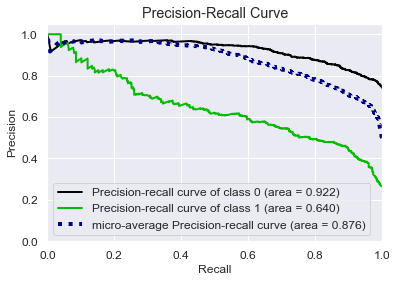

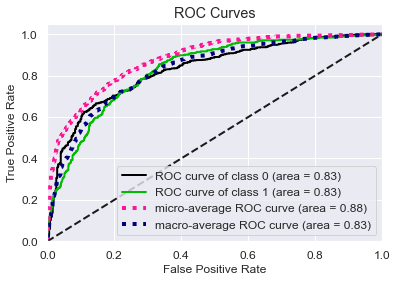

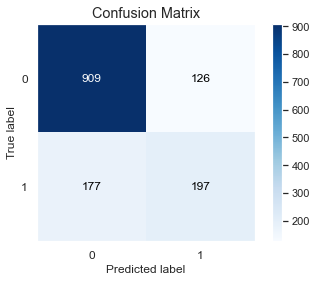

In [115]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
    skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
    skpmetrics.plot_confusion_matrix(ytest,ypreds)

model_eval_bin('xgboost',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h2>  Cross Validation </h2> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
params = {
    'max_depth' : [3,4,5],
    'learning_rate':[0.01,0.05,0.1,0.5],
    'gamma':[0,0.5,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[2,3]
    
}

params_fixed = dict(objective = 'binary:logistic',missing = None,
                    subsample = 0.8,colsample_bytree=0.6)
model = xgb.XGBClassifier(**params_fixed)
grid = GridSearchCV(model,params,scoring='roc_auc',n_jobs=-1,cv=5)

In [118]:
# grid.fit(df_Xtrain,ser_ytrain,
#          early_stopping_rounds = 10,
#          eval_metric           = 'auc',
#          eval_set              = [(df_Xvalid, ser_yvalid)],
#          verbose=False
#         )
# print(grid.best_params_)

In [119]:
params_best = {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4,
               'reg_lambda': 10.0, 'scale_pos_weight': 2}

In [120]:
params = params_fixed
params.update(params_best)

model = xgb.XGBClassifier(**params)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=4,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=10.0,
              scale_pos_weight=2, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

[[805 230]
 [ 99 275]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost_1,0.7665,0.5446,0.7353,0.6257,0.7565


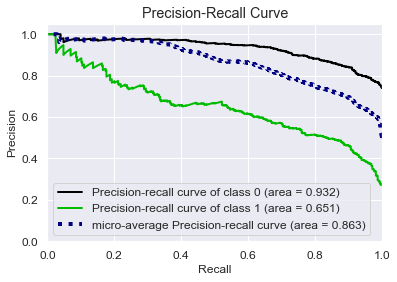

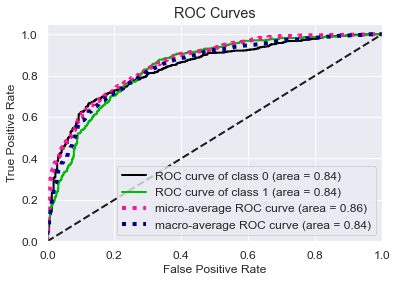

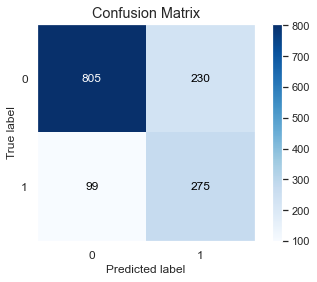

In [121]:
model.fit(df_Xtrain_full,ser_ytrain_full)
ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)

model_eval_bin('xgboost_1',ytest,ypreds,yprobs2d,show_plots=False)

# Hyperband SearchCV

In [122]:
# help(HyperbandSearchCV)

In [123]:
%%time

import scipy.stats as stats
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

# Define our model
params_fixed = {'objective'   : 'binary:logistic', 
                'random_state': SEED,
                'n_jobs'      : 1
               }

params_hyp = {
    'max_depth'        : stats.randint(3,6),
    'learning_rate'    : stats.loguniform(0.01, 1.0),
    'n_estimators'     : stats.randint(100, 1000),
    'subsample'        : [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha'        : stats.loguniform(0.01, 1.0),
    'reg_lambda'       : stats.loguniform(0.01, 1.0),
    'scale_pos_weight' : [2,3,4]
    }

model = xgb.XGBClassifier(**params_fixed)

# Perform Hyperparameter Tuning
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
grid = HyperbandSearchCV(model,params_hyp, 
                              resource_param = 'n_estimators',
                              min_iter       = 100,
                              max_iter       = 1000, # use 1k or 2k
                              cv             = cv, 
                              scoring        = 'roc_auc',
                              refit          = True,
                              verbose        = 0,
                              random_state   = SEED
                          )
# grid.fit(df_Xtrain_full, ser_ytrain_full)
# print('Best parameters:  ', grid.best_params_)

# params_best = grid.best_params_
# params = params_fixed
# params.update(params_best)

CPU times: user 2.7 ms, sys: 74 µs, total: 2.77 ms
Wall time: 2.88 ms


In [124]:
params_best = {'learning_rate': 0.010265426899287895, 'max_depth': 4,
               'n_estimators': 500, 'reg_alpha': 0.390233920364201,
               'reg_lambda': 0.010727782071330185,
               'scale_pos_weight': 3, 'subsample': 0.9}

model = xgb.XGBClassifier(**params_best,random_state=SEED)

model.fit(df_Xtrain_full,ser_ytrain_full)
ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)
print(skmetrics.confusion_matrix(ytest,ypreds))

[[737 298]
 [ 66 308]]


<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1035
           1       0.51      0.82      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409

[[737 298]
 [ 66 308]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost,0.7417,0.5083,0.8235,0.6286,0.7678


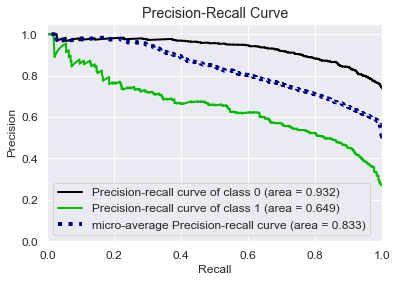

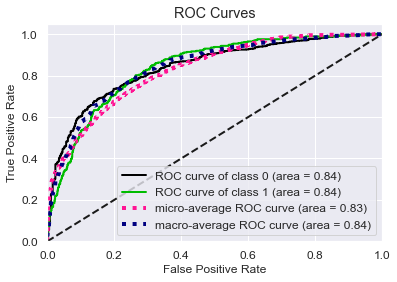

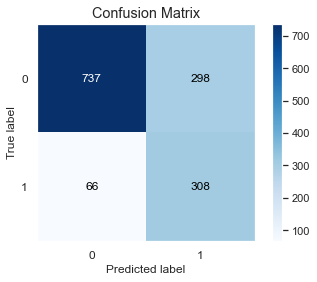

In [125]:
model_eval_bin('xgboost',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [126]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 11 secs
